In [14]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.regression.linear_model import OLS
from pmdarima import auto_arima
from pmdarima.arima import ARIMA
import numpy as np

In [47]:
class Energy:
    def __init__(self) -> None:
        url = "https://raw.githubusercontent.com/owid/energy-data/master/owid-energy-data.csv"
        req = requests.get(url)
        url_content = req.content
        csv_file = open('./data.csv', 'wb')
        csv_file.write(url_content)
        csv_file.close()
        self.data = pd.read_csv("data.csv")

    def print_data(self):
        return self.data.head()

    def clean_data(self):
        self.data = self.data.fillna(0)
        self.data = self.data[["country", "year", "gdp", "renewables_energy_per_capita", "fossil_energy_per_capita"]].reset_index().drop(["index"], axis=1)
        self.data = self.data[(self.data["year"] >= 1970)&(self.data["year"] <= 2018)]        


    def filter_countries(self, countries:list):
        self.data = self.data.set_index("country").T[countries].T.reset_index()
        try:
            self.data["year"] = pd.DatetimeIndex(pd.to_datetime(self.data["year"], format="%Y")).year
            self.data = self.data.set_index("year")
        except KeyError:
            pass

    def plots(self, type:str, countries:list):
        plt.figure(figsize=(16,8))
        for c in countries:
            if type=="renewables":
                plt.plot(self.data[self.data["country"]==c].renewables_energy_per_capita)
                plt.legend(countries)
            elif type=="fossil":
                plt.plot(self.data[self.data["country"]==c].fossil_energy_per_capita)
                plt.legend(countries)                
            elif type=="gdp":
                plt.plot(self.data[self.data["country"]==c].gdp)
                plt.legend(countries)                
      
    def ols_analysis(self):
        Y=self.data["gdp"]
        X=self.data[["fossil_energy_per_capita","renewables_energy_per_capita"]]
        regressor = OLS(Y, X).fit()
        print(regressor.summary())
        
    def arima_forecast(self, countries:list, type:str):
        plt.figure(figsize=(16,8))
        legend = []
        for c in countries:
            if type=="fossil":
                legend.extend([c, f"Predicted for {c}"])
                best_consumption = auto_arima(self.data[self.data["country"]==c].fossil_energy_per_capita,
                                            start_p=1,
                                            start_q=1,
                                            max_p=15,
                                            max_q=15,
                                            m=1,
                                            trace=True,
                                            error_action='ignore',
                                            suppress_warnings=True,
                                            stepwise=True
                                            )
                o = best_consumption.order
                model_c = ARIMA(order=o)
                pred = model_c.fit_predict(y=self.data[self.data["country"]==c].fossil_energy_per_capita, 
                                            x=self.data[self.data["country"]==c].index)

                plt.plot(self.data[self.data["country"]==c].fossil_energy_per_capita)
                plt.plot(pd.Series(pred, index=[t for t in range(2018,2028)]))
                plt.legend(legend)

            if type=="renewables":
                legend.extend([c, f"Predicted for {c}"])
                best_consumption = auto_arima(self.data[self.data["country"]==c].renewables_energy_per_capita,
                                            start_p=1,
                                            start_q=1,
                                            max_p=15,
                                            max_q=15,
                                            m=1,
                                            trace=True,
                                            error_action='ignore',
                                            suppress_warnings=True,
                                            stepwise=True
                                            )
                o = best_consumption.order
                model_c = ARIMA(order=o)
                pred = model_c.fit_predict(y=self.data[self.data["country"]==c].renewables_energy_per_capita, 
                                            x=self.data[self.data["country"]==c].index)

                plt.plot(self.data[self.data["country"]==c].renewables_energy_per_capita)
                plt.plot(pd.Series(pred, index=[t for t in range(2018,2028)]))
                plt.legend(legend)

            if type=="gdp":
                legend.extend([c, f"Predicted for {c}"])
                best_consumption = auto_arima(self.data[self.data["country"]==c].gdp,
                                            start_p=1,
                                            start_q=1,
                                            max_p=15,
                                            max_q=15,
                                            m=1,
                                            trace=True,
                                            error_action='ignore',
                                            suppress_warnings=True,
                                            stepwise=True
                                            )
                o = best_consumption.order
                model_c = ARIMA(order=o)
                pred = model_c.fit_predict(y=self.data[self.data["country"]==c].gdp, 
                                            x=self.data[self.data["country"]==c].index)

                plt.plot(self.data[self.data["country"]==c].gdp)
                plt.plot(pd.Series(pred, index=[t for t in range(2018,2028)]))
                plt.legend(legend)

In [42]:
analysis = Energy()

In [43]:
analysis.print_data()
analysis.clean_data()
analysis.print_data()

,country,year,gdp,renewables_energy_per_capita,fossil_energy_per_capita
70,Afghanistan,1970,1.581223e+10,0.0,0.0
71,Afghanistan,1971,1.577051e+10,0.0,0.0
72,Afghanistan,1972,1.317055e+10,0.0,0.0
73,Afghanistan,1973,1.356863e+10,0.0,0.0
74,Afghanistan,1974,1.430911e+10,0.0,0.0


In [44]:
analysis.filter_countries(["Morocco","Portugal","China","India","United States"])
analysis.data.describe()

,gdp,renewables_energy_per_capita,fossil_energy_per_capita
count,2.450000e+02,245.000000,245.000000
mean,4.093106e+12,1916.634727,22474.819980
std,5.147981e+12,2136.806161,28731.781676
min,4.098229e+10,49.188000,1206.846000
25%,1.872903e+11,212.987000,3509.521000
50%,1.460734e+12,463.340000,7386.754000
75%,6.740172e+12,3773.520000,22964.408000
max,1.815162e+13,8831.973000,89249.977000


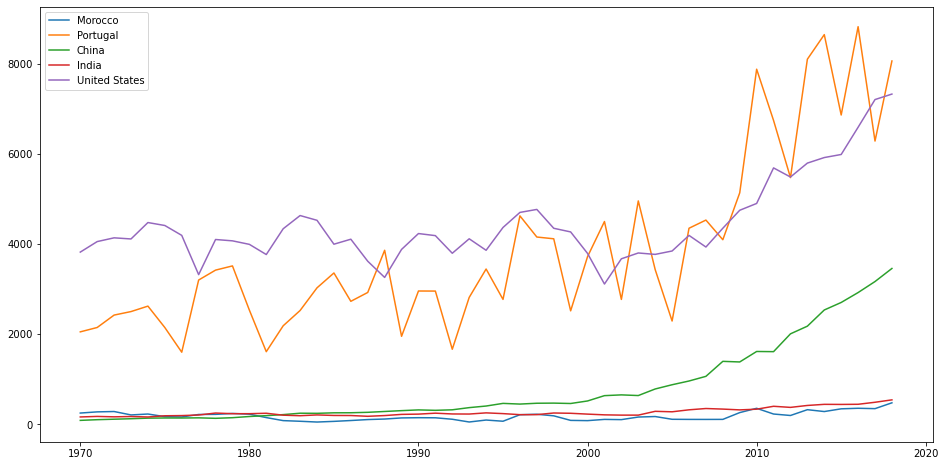

In [45]:
analysis.plots("renewables", countries=["Morocco","Portugal","China","India","United States"])

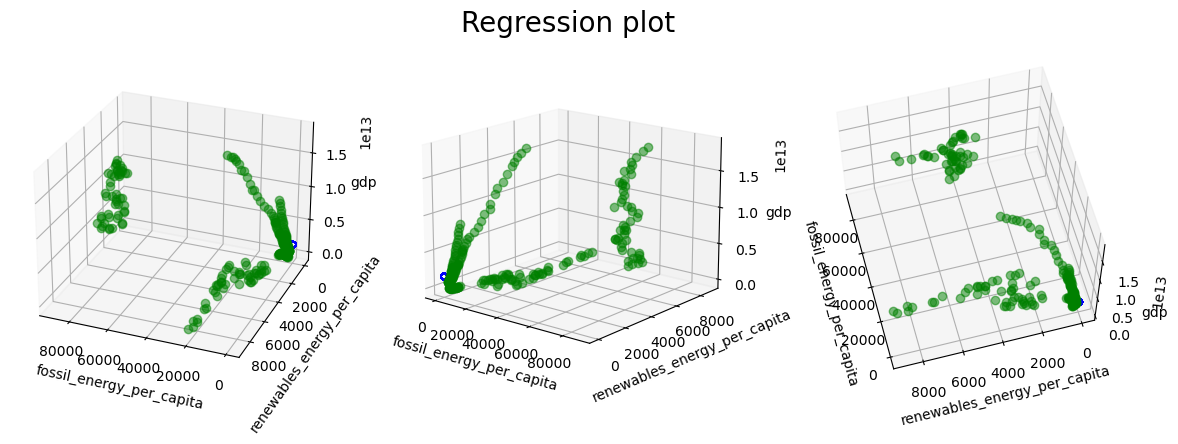

In [84]:
from sklearn.linear_model import LinearRegression
Y=analysis.data["gdp"].values
X=analysis.data[["fossil_energy_per_capita","renewables_energy_per_capita"]].values.reshape(-1,2)

x = X[:, 0]
y = X[:, 1]
z = Y

x_pred = np.linspace(6, 24, 30)      
y_pred = np.linspace(0.93, 2.9, 30)  
xx_pred, yy_pred = np.meshgrid(x_pred, y_pred)
model_viz = np.array([xx_pred.flatten(), yy_pred.flatten()]).T


ols = LinearRegression()
model = ols.fit(X, Y)
predicted = model.predict(model_viz)


r2 = model.score(X, Y)

plt.style.use('default')

fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

axes = [ax1, ax2, ax3]

for ax in axes:
    ax.plot(x, y, z, color='green', zorder=15, linestyle='none', marker='o', alpha=0.5)
    ax.scatter(xx_pred.flatten(), yy_pred.flatten(), predicted, facecolor=(0,0,0,0), s=20, edgecolor='blue')
    ax.set_xlabel('fossil_energy_per_capita', fontsize=10)
    ax.set_ylabel('renewables_energy_per_capita', fontsize=10)
    ax.set_zlabel('gdp', fontsize=10)
    ax.locator_params(nbins=4, axis='x')
    ax.locator_params(nbins=5, axis='x')


ax1.view_init(elev=27, azim=112)
ax2.view_init(elev=16, azim=-51)
ax3.view_init(elev=60, azim=165)

fig.suptitle("Regression plot", fontsize=20)

fig.tight_layout()

In [75]:
X

array([[1.6474380e+03],
       [2.4868300e+02],
       [1.6993180e+03],
       [2.7488600e+02],
       [1.8069620e+03],
       [2.8264900e+02],
       [2.0665410e+03],
       [2.0674700e+02],
       [2.1522330e+03],
       [2.2704100e+02],
       [2.1974290e+03],
       [1.6881700e+02],
       [2.3456550e+03],
       [1.6215700e+02],
       [2.5324380e+03],
       [2.1677100e+02],
       [2.6312040e+03],
       [2.1968200e+02],
       [2.8654520e+03],
       [2.3968700e+02],
       [2.8161910e+03],
       [2.2410400e+02],
       [2.7306200e+03],
       [1.4785200e+02],
       [2.8144310e+03],
       [8.0604000e+01],
       [2.8354770e+03],
       [6.6169000e+01],
       [2.8233730e+03],
       [4.9188000e+01],
       [2.8385860e+03],
       [6.3873000e+01],
       [2.8560850e+03],
       [8.2738000e+01],
       [2.8628320e+03],
       [1.0404300e+02],
       [2.9585130e+03],
       [1.1578800e+02],
       [3.1789710e+03],
       [1.4047000e+02],
       [3.1905010e+03],
       [1.454210

In [46]:
analysis.ols_analysis()

                                 OLS Regression Results                                
Dep. Variable:                    gdp   R-squared (uncentered):                   0.624
Model:                            OLS   Adj. R-squared (uncentered):              0.621
Method:                 Least Squares   F-statistic:                              201.4
Date:                Tue, 29 Nov 2022   Prob (F-statistic):                    2.64e-52
Time:                        12:09:33   Log-Likelihood:                         -7458.7
No. Observations:                 245   AIC:                                  1.492e+04
Df Residuals:                     243   BIC:                                  1.493e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

InvalidIndexError: (slice(None, None, None), 0)

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2251.624, Time=0.08 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2267.397, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2256.476, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=2238.490, Time=0.03 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=2241.632, Time=0.07 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.43 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=2250.023, Time=0.07 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.752 seconds


c:\Users\farou\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\farou\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: x. After release 0.14, this will raise.
  warnings.warn(


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2278.643, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2277.089, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2282.337, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2277.869, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2302.889, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.289 seconds


c:\Users\farou\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: x. After release 0.14, this will raise.
  warnings.warn(


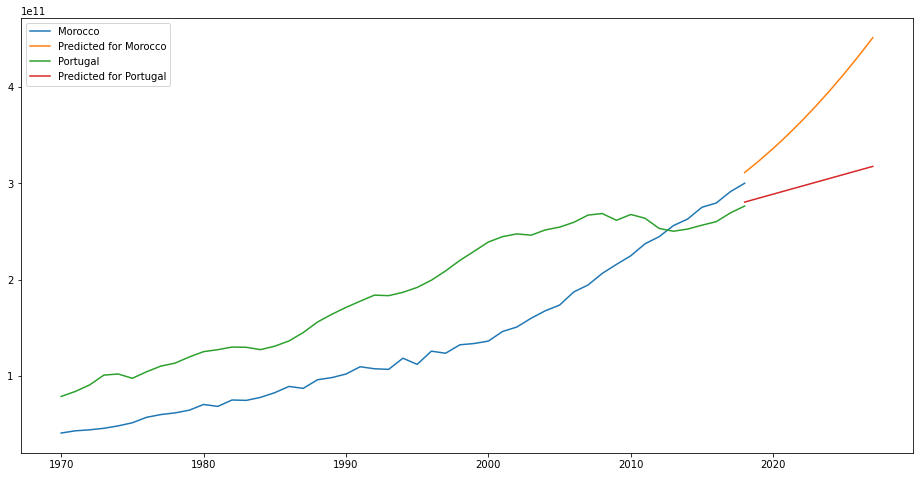

In [10]:
analysis.arima_forecast(countries=["Morocco", "Portugal"], type="gdp")

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=537.194, Time=0.10 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=582.753, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=538.332, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=549.693, Time=0.08 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=538.290, Time=0.18 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=536.047, Time=0.12 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=539.332, Time=0.13 sec
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=538.034, Time=0.21 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=537.979, Time=0.23 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=540.885, Time=0.32 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=inf, Time=0.35 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=534.427, Time=0.22 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=537.800, Time=0.19 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=535.818, Time=0.14 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=536.682, 

c:\Users\farou\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: x. After release 0.14, this will raise.
  warnings.warn(


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=454.976, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=451.174, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=453.052, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=453.030, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=453.579, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.274 seconds


c:\Users\farou\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: x. After release 0.14, this will raise.
  warnings.warn(


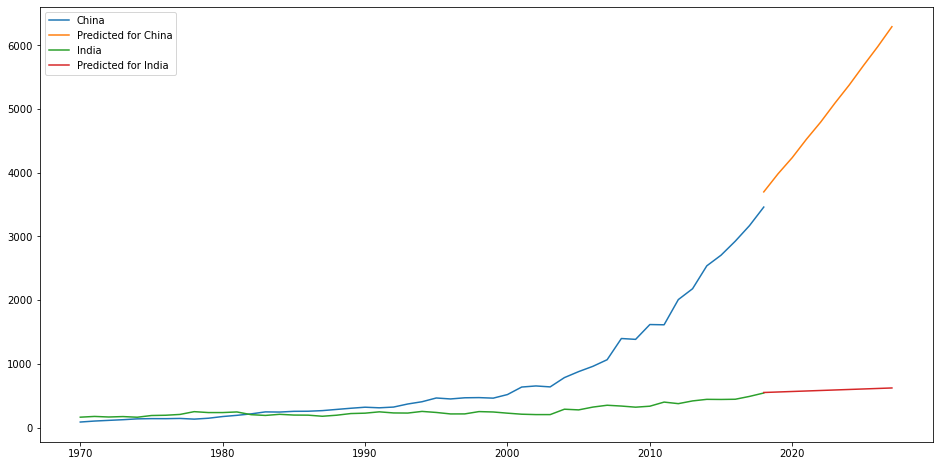

In [11]:
analysis.arima_forecast(countries=["China", "India"], type="renewables")